In [9]:
import pydicom
import os
import numpy as np

def load_dicom_slices(folder_path):
    # List to hold the slices
    slices = []
    
    # Loop through all files in the directory
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.dcm'):
            # Load the DICOM file
            dicom_file_path = os.path.join(folder_path, filename)
            dicom_data = pydicom.dcmread(dicom_file_path)
            
            # Extract pixel array (assuming it's 512x512)
            slices.append(dicom_data.pixel_array)
    
    # Stack the slices into a 3D NumPy array (slices, 512, 512)
    dicom_stack = np.stack(slices, axis=0)
    
    return dicom_stack

# Usage
folder_path = f'/media/joaob/DATA-LINUX/LIDC-IDRI/LIDC-IDRI-0001/1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192/1-032.dcm'  # Replace with the actual folder path
dicom_data = pydicom.dcmread(folder_path)

#print(dicom_data.shape)  # Output should be (number_of_slices, 512, 512)


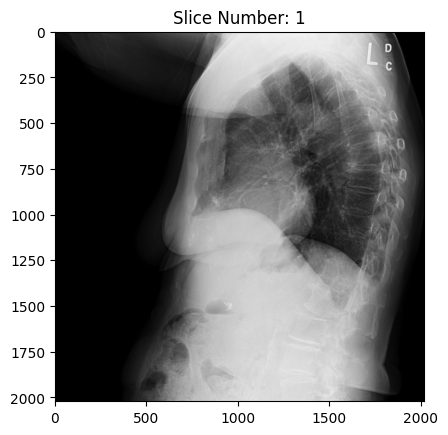

In [8]:
import matplotlib.pyplot as plt
i=1 #slice number <i>

image = dicom_array[i]
# Display the image
plt.imshow(image, cmap='gray')
plt.title(f"Slice Number: {i}")
plt.show()

In [47]:
#store in disk the aggregation of dicom images
#os.mkdir('./LIDC-DATASET/')
#os.mkdir('./LIDC-DATASET/LIDC-IDRI-0001/')
#np.save("./LIDC-DATASET/LIDC-IDRI-0001/scan.npy" , dicom_array)

#load
#np.load("./LIDC-DATASET/LIDC-IDRI-0001/scan.npy")

# ========================

In [1]:
import pydicom
import os
import numpy as np
import shutil
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt

In [28]:
import pydicom
import os
import numpy as np
import shutil
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt

#path to directory were CT scans (*.dcm) are
LIDC_PATH = f"/media/joaob/DATA-LINUX/LIDC-IDRI/"

#path to directory were xml files are
XML_PATH = f"/media/joaob/DATA-LINUX/LIDC-XML/" 

#path to store the processed data
SAVE_PATH = f"./LIDC-DATASET/"


# ================================================================================================
#       script para guardar apenas imagens onde exite nodulo usando informacao das anotaçoes
# ================================================================================================

#create base folder if it doesn't existe
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)



for xml_f in sorted(os.listdir(XML_PATH)):
    xml_files = sorted(os.listdir(f"{XML_PATH}{xml_f}"))
    
    for file in xml_files:
        # Load the XML file
        tree = ET.parse(f"{XML_PATH}{xml_f}/{file}")
        root = tree.getroot()

        if root.tag == '{http://www.nih.gov/idri}IdriReadMessage': # true for XRs annotations | we only want CTs so just ignore XRs
            continue

        print(f"XML: {file}")
        done = False
        dicom_stack = None


        #find the patient (path to folder) related to xml file
        study_instance_uid = root.find('.//{*}StudyInstanceUID').text #first folder
        series_instance_uid = root.find('.//{*}SeriesInstanceUid').text #subfolder
        scans_path = None
        patient_id = None
        patient = None

        for patient_name in sorted(os.listdir(f'{LIDC_PATH}')):
            if done: break
            for study_uid in sorted(os.listdir(f'{LIDC_PATH}/{patient_name}')):

                if study_uid == study_instance_uid: # .xml file correspond with scans
                    print(f'paciente: {patient_name}')
                    patient = patient_name
                    patient_id = patient_name[-4:]
                    done = True
                    scans_path = f'{LIDC_PATH}{patient}/{study_instance_uid}/{series_instance_uid}/'
                    break
        
        
        nodule_count = 1 #variavel para controlar o id de cada nodulo
        #processe the data
        # Find all unblindedReadNodule elements
        unblinded_read_nodules = root.findall('.//{*}unblindedReadNodule')
        # Iterate over each unblindedReadNodule to extract characteristics and imageSOP_UID
        for nodule in unblinded_read_nodules:

            nodule_id = f"{"0"*(3-len(str(nodule_count)))}{nodule_count}"
            annotation_id = f"{patient_id}_{nodule_id}" #id for each annotation 
            
            # Check if the nodule contains characteristics and extract them
            # if it doesn't have we skip because only the ones with characteristics matter
            characteristics = nodule.find('{*}characteristics')
            if characteristics is not None:
                print(f'Nodule ID: {nodule_count}')
                subtlety = characteristics.find('{*}subtlety').text if characteristics.find('{*}subtlety') is not None else 'N/A'
                internal_structure = characteristics.find('{*}internalStructure').text if characteristics.find('{*}internalStructure') is not None else 'N/A'
                calcification = characteristics.find('{*}calcification').text if characteristics.find('{*}calcification') is not None else 'N/A'
                sphericity = characteristics.find('{*}sphericity').text if characteristics.find('{*}sphericity') is not None else 'N/A'
                margin = characteristics.find('{*}margin').text if characteristics.find('{*}margin') is not None else 'N/A'
                lobulation = characteristics.find('{*}lobulation').text if characteristics.find('{*}lobulation') is not None else 'N/A'
                spiculation = characteristics.find('{*}spiculation').text if characteristics.find('{*}spiculation') is not None else 'N/A'
                texture = characteristics.find('{*}texture').text if characteristics.find('{*}texture') is not None else 'N/A'
                malignancy = characteristics.find('{*}malignancy').text if characteristics.find('{*}malignancy') is not None else 'N/A'

                print(f'  Subtlety: {subtlety}')
                print(f'  Internal Structure: {internal_structure}')
                print(f'  Calcification: {calcification}')
                print(f'  Sphericity: {sphericity}')
                print(f'  Margin: {margin}')
                print(f'  Lobulation: {lobulation}')
                print(f'  Spiculation: {spiculation}')
                print(f'  Texture: {texture}')
                print(f'  Malignancy: {malignancy}')

                # Iterate through all <roi> tags in the current nodule
                rois = nodule.findall('{*}roi')
                slices = []
                for roi in rois:
                    image_sop_uid = roi.find('{*}imageSOP_UID').text
                    print(f'  ROI imageSOP_UID: {image_sop_uid}')
                    
                    for filename in sorted(os.listdir(scans_path)):
                        if filename.endswith('.dcm'):
                            # Load the DICOM file
                            dicom_file_path = os.path.join(scans_path, filename)
                            dicom_data = pydicom.dcmread(dicom_file_path)
                            
                            if dicom_data.SOPInstanceUID == image_sop_uid:
                            # Extract pixel array
                                slices.append(dicom_data.pixel_array)
                                break

                    '''
                    # extair coordenadas dos edges do nodulo
                    '''
                    for edge_map in roi.findall('{*}edgeMap'):
                        x_coord = edge_map.find('{*}xCoord').text
                        y_coord = edge_map.find('{*}yCoord').text
                        print(f'    EdgeMap - x: {x_coord}, y: {y_coord}')
                        break

                #for image in slices:
                #    # Display the image
                #    plt.imshow(image, cmap='gray')
                #    plt.show()


                if not os.path.exists(f'{SAVE_PATH}{patient}/'):
                    os.mkdir(f'{SAVE_PATH}{patient}/')

                if not os.path.exists(f'{SAVE_PATH}{patient}/nodule_{annotation_id}'):
                    os.mkdir(f'{SAVE_PATH}{patient}/nodule_{annotation_id}')

                #stack com as imagens onde existe um nodulo
                dicom_stack = np.stack(slices, axis=0)  
                np.save(f'{SAVE_PATH}{patient}/nodule_{annotation_id}/scan.npy' , dicom_stack)

                nodule_count += 1
                #provavelmente vamos guardar os dados num ficheiro csv em vez de guardar o xml
                #shutil.copy(f'{XML_PATH}{xml_f}/{file}', f'{SAVE_PATH}{patient}/CT') #copy .xml file to the respective patient folder
                

            else:
                continue
    
    
        
        break       
    break


XML: 158.xml
paciente: LIDC-IDRI-0078
Nodule ID: 1
  Subtlety: 5
  Internal Structure: 1
  Calcification: 6
  Sphericity: 3
  Margin: 4
  Lobulation: 1
  Spiculation: 1
  Texture: 5
  Malignancy: 3
  ROI imageSOP_UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.498089111228175009979138545584
    EdgeMap - x: 364, y: 172
  ROI imageSOP_UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.163230259801838781207059567328
    EdgeMap - x: 352, y: 183
  ROI imageSOP_UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.554419374464496085900992574496
    EdgeMap - x: 361, y: 182
  ROI imageSOP_UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.333090359302582251744904040987
    EdgeMap - x: 360, y: 184
  ROI imageSOP_UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.795216975697425366378873778646
    EdgeMap - x: 367, y: 182
  ROI imageSOP_UID: 1.3.6.1.4.1.14519.5.2.1.6279.6001.206828858093253510448843889557
    EdgeMap - x: 367, y: 179
Nodule ID: 2
  Subtlety: 4
  Internal Structure: 1
  Calcification: 6
  Sphericity: 4
  Margin: 4
  Lobulation: 1
  Sp

In [3]:
f68 = '/home/joaob/Documents/GitHub/Lab_IACD_Project_1/LIDC-DATASET/LIDC-IDRI-0001/XR/068.xml'
f69 = '/home/joaob/Documents/GitHub/Lab_IACD_Project_1/LIDC-DATASET/LIDC-IDRI-0001/CT/069.xml'

tree1 = ET.parse(f68)
root1 = tree1.getroot()
print(root1.tag)

tree2 = ET.parse(f69)
root2 = tree2.getroot()
print(root2.tag)

{http://www.nih.gov/idri}IdriReadMessage
{http://www.nih.gov}LidcReadMessage


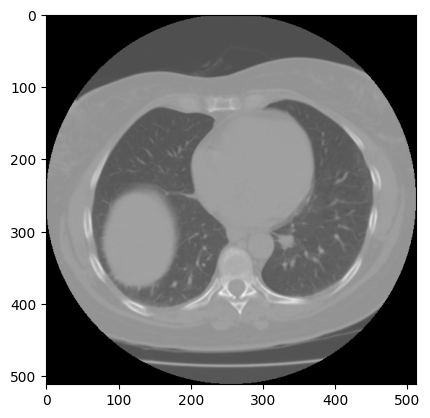

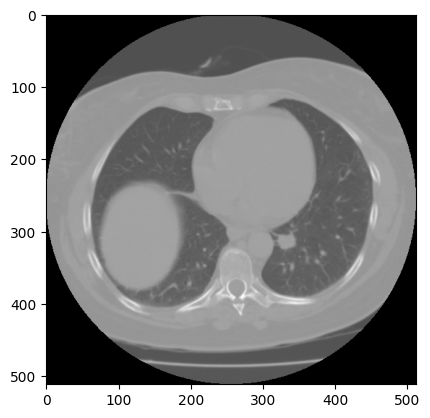

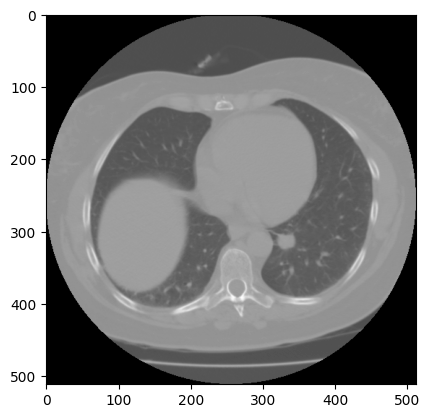

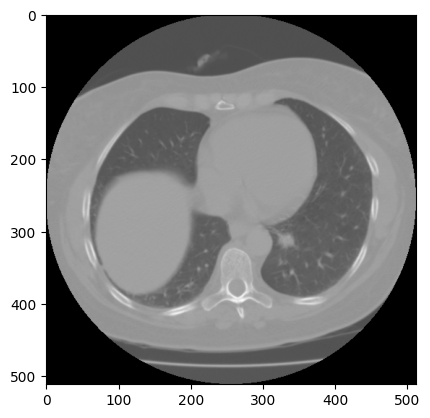

In [4]:
for image in dicom_stack:
    # Display the image
    plt.imshow(image, cmap='gray')
    plt.show()
